随着网络层数加深，模型出现两个严重问题：
- 梯度消失/爆炸，导致难以训练
- 准确率下降（即便没有过拟合）← 这是深层网络的退化问题

ResNet（Residual Network） 是一种特别设计的深层卷积神经网络，引入了所谓的 “残差连接（Residual Connection）” 来解决深层网络训练困难的问题。残差网络的核心思想是：每个附加层都应该更容易地包含原始函数作为其元素之一。
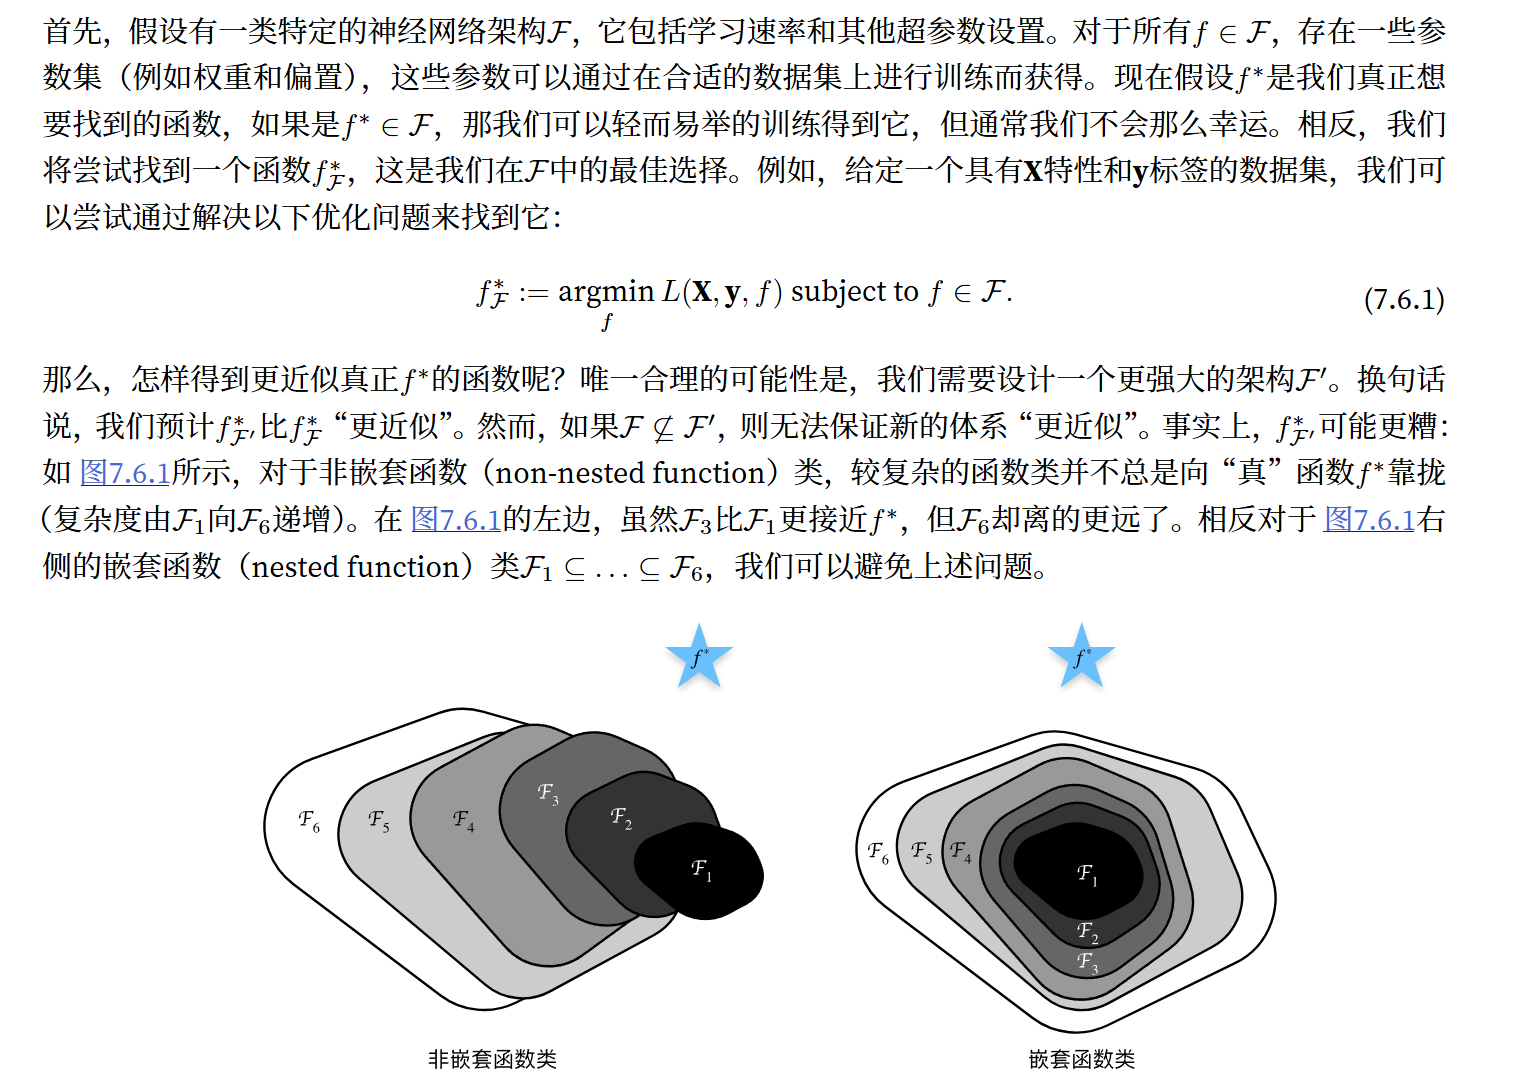

如图7.6.2所示，假设我们的原始输入为x，而希望学出的理想映射为f (x)（作为图7.6.2上方激活函数的输入）。图7.6.2左图虚线框中的部分需要直接拟合出该映射f (x)，而右图虚线框中
的部分则需要拟合出残差映射f (x) − x。残差映射在现实中往往更容易优化。以本节开头提到的恒等映射作为我们希望学出的理想映射f (x)，我们只需将 图7.6.2中右图虚线框内上方的加权运算（如仿射）的权重和偏置参数设成0，那么f (x)即为恒等映射。实际中，当理想映射f (x)极接近于恒等映射时，残差映射也易于捕捉恒等映射的细微波动。

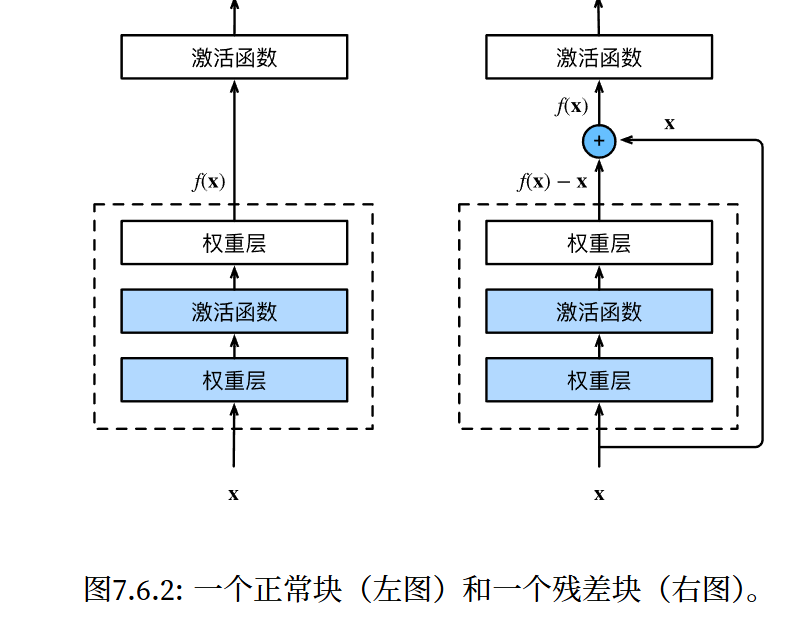

小结
- 学习嵌套函数（nested function）是训练神经网络的理想情况。在深层神经网络中，学习另一层作为恒等映射（identity function）较容易（尽管这是一个极端情况）。
- 残差映射可以更容易地学习同一函数，例如将权重层中的参数近似为零。
- 利用残差块（residual blocks）可以训练出一个有效的深层神经网络：输入可以通过层间的残余连接更快地向前传播。
- 残差网络（ResNet）对随后的深层神经网络设计产生了深远影响。

In [3]:
import torch 
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):#@save
    def __init__(self,input_channels,num_channels,
                use_1x1conv=False,strides=1):
        super().__init__()
        self.conv1=nn.Conv2d(input_channels,num_channels,kernel_size=3,padding=1,stride=strides)
        self.conv2=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
        if use_1x1conv:
            self.conv3=nn.Conv2d(input_channels,num_channels,kernel_size=1,stride=strides)
        else:
            self.conv3=None
        self.bn1=nn.BatchNorm2d(num_channels)
        self.bn2=nn.BatchNorm2d(num_channels)
    def forward(self,X):
        Y=F.relu(self.bn1(self.conv1(X)))
        Y=self.bn2(self.conv2(Y))
        if self.conv3:
            X=self.conv3(X)
        Y+=X
        return F.relu(Y)

In [6]:
blk=Residual(3,3)
X=torch.rand(4,3,6,6)
Y=blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [7]:
#我们也可以在增加输出通道数的同时，减半输出的高和宽。
blk=Residual(3,6,use_1x1conv=True,strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [8]:
#ResNet模型
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm2d(64), nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
#实现resnet模块，我们对第一个模块做了特别处理。
def resnet_block(input_channels,num_channels,num_residuals,first_block=False):
    blk=[]
    for i in range(num_residuals):
        if i==0 and not first_block:
            blk.append(Residual(input_channels,num_channels,use_1x1conv=True,strides=2))
        else:
            blk.append(Residual(num_channels,num_channels))
    return blk

In [ ]:
#接着在ResNet加入所有残差块，这里每个模块使用2个残差块。
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [12]:
net=nn.Sequential(b1,b2,b3,b4,b5,
                  nn.AdaptiveAvgPool2d((1,1)),
                  nn.Flatten(),nn.Linear(512,10))

每个模块有4个卷积层（不包括恒等映射的1 × 1卷积层）。加上第一个7 × 7卷积层和最后一个全连接层，共有18层。因此，这种模型通常被称为ResNet‐18。通过配置不同的通道数和模块里的残差块数可以得到不同的ResNet模型，例如更深的含152层的ResNet‐152。虽然ResNet的主体架构跟GoogLeNet类似，但ResNet架构更简单，修改也更方便。这些因素都导致了ResNet迅速被广泛使用。

In [13]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.009, train acc 0.998, test acc 0.895
2683.5 examples/sec on cuda:0


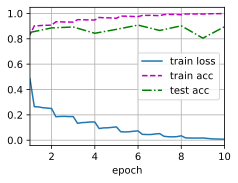

In [14]:
#训练模型
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())